# Introduction
This notebook intends to present the application of neural networks in the context of option pricing in an accessible and hands-on manner.

Goals are to illustrate the idea of applying neural networks to pricing as well as to give an introduction to the concepts required to use tensorflow and keras for modelling.
- **Technical requirements**: Python 3 with the packages below as well as Jupyter are required for a manual run; to view the notebook precompiled regularly **Google Colab** or **Jupyter Notebook/Lab** is sufficient.


In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
 
import seaborn as sns

from tqdm.keras import TqdmCallback

from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())],
                        columns=dictionary.keys())


Lets first define a valuation function of interest, in this case the Black76 formula is selected.

In [70]:
def Black76(forward_price,strike,volatility,maturity,option_type): 
    d_1 = np.log(forward_price/strike)/(volatility*np.sqrt(maturity))+(volatility*np.sqrt(maturity))/2
    d_2 = np.log(forward_price/strike)/(volatility*np.sqrt(maturity))-(volatility*np.sqrt(maturity))/2
    value = option_type * (forward_price*norm.cdf(option_type*d_1)-strike*norm.cdf(option_type*d_2))
    return value

## Data generation

Using neural networks for pricing means the interpolation and extrapolation is known prices such that new configurations in the possible data space are inferred by the network by generalizing the relationships in the reference data.

For this purpose, a plausible range of data for different degrees of freedom of the formula must be formulated. 

In [135]:
label_dict = {
    'forward_price' : (1, 200),
    'strike'            : (1, 200),
    'volatility'          : (0, 2),
    'maturity'            : (0, 20),
    'option_type'            : (1.0,1.0),
}

Random samples must be taken from this data space such that the coverage of the space is optimal. A uniformly random exploration of the space guarantees even coverage.


In [136]:
def uniform_sample(label_dict, n_samples_base2):

    n_labels = 0
    for l in label_dict: 
        if label_dict[l][0] < label_dict[l][1]:
            n_labels += 1
        sample = np.random.uniform(size=(2**n_samples_base2, n_labels))

    mean = sample.mean(axis=0, keepdims=True)
    sample += (0.5 - mean)
    
    sample_full = np.zeros((sample.shape[0], len(label_dict.keys())))
    k = 0
    for col, l in enumerate(label_dict):
        if label_dict[l][0] < label_dict[l][1]:
            sample_full[:,col] = sample[:,k]
            k += 1
    
    a = np.array([ label_dict[l][0] for l in label_dict ]).reshape((1,-1))
    b = np.array([ label_dict[l][1] for l in label_dict ]).reshape((1,-1))
    
    sample = a + (b-a) * sample_full
    return sample

def Black76_apply(args):
    return Black76(args[0],args[1],args[2],args[3],args[4])

For this example, the sample size is given as a power of 2 such that the quasi-random number generation retains its theoretical properties.

In [137]:
sample_size = 15
2**sample_size

32768

In [138]:
features = uniform_sample(label_dict,sample_size)

In [139]:
features

array([[116.38851037,  78.27028811,   1.18472741,   8.77717543,
          1.        ],
       [136.0505906 , 110.90623715,   0.66139333,   6.68217016,
          1.        ],
       [115.77974199, 192.8537029 ,   0.40632707,   7.1462094 ,
          1.        ],
       ...,
       [172.7274773 , 155.16262289,   1.07961904,   7.74743733,
          1.        ],
       [ 67.18095782, 168.08394118,   0.75286828,   0.87825861,
          1.        ],
       [ 98.17859996, 143.46162244,   1.56237732,  17.5783013 ,
          1.        ]])

In [140]:
labels =np.apply_along_axis(Black76_apply, 1, features)

In [141]:
labels

array([108.85696819,  87.98369115,  31.27381045, ..., 150.96919913,
         3.27143898,  98.05349338])

The data space can be visualized in the following way:

In [144]:
# Define Dataset

x =  pd.DataFrame(features).iloc[:,0].astype(float)
y =  pd.DataFrame(features).iloc[:,1].astype(float)
z =  pd.DataFrame(features).iloc[:,2].astype(float)
col =  pd.DataFrame(features).iloc[:,3].astype(float)
#col = labels
 
# Creating figure

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
  
# Creat color map

color_map = plt.get_cmap('cool')
 
# Create scatter plot and colorbar

scatter_plot = ax.scatter3D(x, y, z,
                            c=col,
                            cmap = color_map,s=1)
 
plt.colorbar(scatter_plot)
ax.set_xlabel("Forward rate", rotation=0)
ax.set_ylabel("Strike", rotation=0)
ax.set_zlabel("Volatility", rotation=180)
ax.set_title('Colored maturity',fontsize=16)


Text(0.5, 0.92, 'Colored maturity')

## Data preparation

In machine learning, a common validation strategy, referred to as the holdout method, splits the data in train and validation/test.

Here, we take a random 70% of the sample as training data, the remaining data will not be used by the model as training data and serves as independent validation.

In [133]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    train_size=0.7,   # fraction of data set used for training
    random_state=42,  # random seed for splitting
)

## Technical model setup

The most convenient way to experiment with neural networks is to standardize the model definition and the model training.

In the following, a function defines a conventional feedforward neural network with a certain number of Dense layers, a speficied number of Neurons per layer with given activations.

In [134]:
def extended_model(
        num_features,    
        num_layers_mid = 4,    # number of hidden layers
        num_units_mid  = 128,  # number of units in hidden layers
        activation     = 'swish',  # activation function (for each unit)
        batch_normalization = False):

    input_ = tf.keras.Input(shape=(num_features,))
    
    out = input_
    
    for k in range(num_layers_mid):
        if batch_normalization:
            out=tf.keras.layers.BatchNormalization()(out)

        out = tf.keras.layers.Dense(num_units_mid, activation=activation)(out)
        
    # final output
    out = tf.keras.layers.Dense(1)(out)
    return tf.keras.Model(input_, out)

In [50]:
def train_model(
    model,                                                  # the tf.keras.Model to be trained
    features,                                               # the features data set used for training
    labels,                                                 # the labels data set used for training
    validation_features,                                    # validation data set features
    validation_labels,                                      # validation data set labels
    optimizer     = tf.keras.optimizers.Adam,               # optimization method, e.g. Adam or SGD
    loss          = tf.keras.losses.MeanAbsoluteError(),    # loss function (object), e.g. MeanAbsoluteError or MeanSquaredError
    epochs        = 1024,                                   # number of training runs (full iterations)
    batch_size    = 512,                                    # number of samples evaluated for a single update (gradient step)
    learning_rate = 0.001,                                  # gradient descent step size multiplier
    patience      = 100,                                    # allow for early stopping if no more progress for n iterations
    metrics       = [                                       # a list of usefull metrices for analysis
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
    ],
    validation_freq = 1,                                    # specify how many training epochs to run before a new validation run is performed
    verbose         = 0,                                    # how much details are printed
    ):
    """
    A convenience wrapper for tf.keras.Model training.
    """
    #
    model.compile(loss=loss, optimizer=optimizer(learning_rate=learning_rate), metrics=metrics)
   
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience),
        TqdmCallback(verbose=0),
    ]
    validation_data = None
    if validation_features is not None and validation_labels is not None:
        validation_data = (validation_features, validation_labels)
    history = model.fit(
        x = features,
        y = labels,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = validation_data,
        validation_freq = validation_freq,
        callbacks = callbacks,
        verbose = verbose,
        )
    return history

## Model setup - Example 

A tensorflow model is created by calling the function with the required parameters. 

In [51]:
model = extended_model(num_features = 5,
        num_layers_mid = 4,    # number of hidden layers
        num_units_mid  = 128,  # number of units in hidden layers
        activation     = 'swish',  # activation function (for each unit)
        batch_normalization = True,
)

In [53]:
model.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 5)]               0         
                                                                 
 batch_normalization_76 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_113 (Dense)           (None, 128)               768       
                                                                 
 batch_normalization_77 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_114 (Dense)           (None, 128)               16512     
                                                                 
 batch_normalization_78 (Bat  (None, 128)              512

Tensorflow takes care of optimization and performance tracking. Callbacks allow to define custom return values from the training such that e.g. epoch training times can be requested.

In [54]:
history = train_model(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
    optimizer     = tf.keras.optimizers.Adam,               # optimization method, e.g. Adam or SGD
    loss          = tf.keras.losses.MeanSquaredError(),     # loss function (object), e.g. MeanAbsoluteError or MeanSquaredError
    epochs        = 25,                                    # number of training runs (full iterations)
    batch_size    = 512,                                    # number of samples evaluated for a single update (gradient step)
    learning_rate = 0.001,                                  # gradient descent step size multiplier
    patience      = 100,                                    # allow for early stopping if no more progress for n iterations
    metrics       = [                                       # a list of usefull metrices for analysis
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
    ],
    validation_freq = 1,                                    # specify how many training epochs to run before a new validation run is performed
    verbose         = 0,                                    # how much details are printed
)

0epoch [00:00, ?epoch/s]

In [57]:
history

## Diagnostics

After training a model, the convergence of the training should be examined.

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model selection and HPO

Models are incredibly sensitive with respect to their architectures and hyperparameters. Therefore, a grid search is performed next with the following search space:

In [59]:
dictionary = {'learning_rate': [0.00001,0.0001, 0.001, 0.01,0.1,1],
              'n_neurons': ['8','64', '256'],
              'n_layers': [1, 3]}

In [60]:
search_space = expand_grid(dictionary)

In [61]:
search_space

learning_rate n_neurons  n_layers
0         0.00001         8         1
1         0.00001         8         3
2         0.00001        64         1
3         0.00001        64         3
4         0.00001       256         1
5         0.00001       256         3
6         0.00010         8         1
7         0.00010         8         3
8         0.00010        64         1
9         0.00010        64         3
10        0.00010       256         1
11        0.00010       256         3
12        0.00100         8         1
13        0.00100         8         3
14        0.00100        64         1
15        0.00100        64         3
16        0.00100       256         1
17        0.00100       256         3
18        0.01000         8         1
19        0.01000         8         3
20        0.01000        64         1
21        0.01000        64         3
22        0.01000       256         1
23        0.01000       256         3
24        0.10000         8         1
25        0.10000         8         3
26        0.10000        64         1
27        0.10000        64         3
28        0.10000       256         1
29        0.10000       256         3
30        1.00000         8         1
31        1.00000         8         3
32        1.00000        64         1
33        1.00000        64         3
34        1.00000       256         1
35        1.00000       256         3

We track all intermediate results as well as histories and validation losses to later identify the best-performing models. 

In [19]:
result_list = []
result_list_history = []
result_list_models = []
for i,j in search_space.iterrows():
    model = extended_model(num_features = 5,
        num_layers_mid = j.n_layers,    # number of hidden layers
        num_units_mid  = j.n_neurons,  # number of units in hidden layers
        activation     = 'swish',  # activation function (for each unit)
        batch_normalization = True,
    )
    history = train_model(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
    optimizer     = tf.keras.optimizers.Adam,               # optimization method, e.g. Adam or SGD
    loss          = tf.keras.losses.MeanSquaredError(),     # loss function (object), e.g. MeanAbsoluteError or MeanSquaredError
    epochs        = 20,                                    # number of training runs (full iterations)
    batch_size    = 512,                                    # number of samples evaluated for a single update (gradient step)
    learning_rate = j.learning_rate,                                  # gradient descent step size multiplier
    patience      = 100,                                    # allow for early stopping if no more progress for n iterations
    metrics       = [                                       # a list of usefull metrices for analysis
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
    ],
    validation_freq = 1,                                    # specify how many training epochs to run before a new validation run is performed
    verbose         = 0,                                    # how much details are printed
)
    
    result_list.append(history.history["val_loss"][-1])
    result_list_history.append(history)
    result_list_models.append(model)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

In [20]:
search_space_result = search_space.copy()
search_space_result['result'] = result_list

In [21]:
search_space_result

learning_rate n_neurons  n_layers       result
0         0.00001         8         1  8955.873047
1         0.00001         8         3  8974.013672
2         0.00001        64         1  9004.951172
3         0.00001        64         3  8625.805664
4         0.00001       256         1  8969.959961
5         0.00001       256         3  5341.686523
6         0.00010         8         1  8900.286133
7         0.00010         8         3  8504.544922
8         0.00010        64         1  8628.694336
9         0.00010        64         3  2240.081055
10        0.00010       256         1  7661.229980
11        0.00010       256         3   374.420898
12        0.00100         8         1   503.537750
13        0.00100         8         3   120.540092
14        0.00100        64         1   190.224487
15        0.00100        64         3    69.278122
16        0.00100       256         1   192.694275
17        0.00100       256         3    95.489647
18        0.01000         8         1    96.962372
19        0.01000         8         3   103.436806
20        0.01000        64         1    53.297840
21        0.01000        64         3    51.039993
22        0.01000       256         1    41.738811
23        0.01000       256         3    23.789415
24        0.10000         8         1    72.971748
25        0.10000         8         3    51.109882
26        0.10000        64         1    22.617476
27        0.10000        64         3    60.746738
28        0.10000       256         1    25.871489
29        0.10000       256         3    17.699987
30        1.00000         8         1   144.992523
31        1.00000         8         3   235.593475
32        1.00000        64         1    57.740864
33        1.00000        64         3    28.204664
34        1.00000       256         1    77.810204
35        1.00000       256         3  3381.137451

A model can now be analyzed more rigorously to identify properties beyong a simple loss. 

Properties of interest could be:
- Behaviour of the model for different product types
- Sensitivities with respect to certain hyper parameters


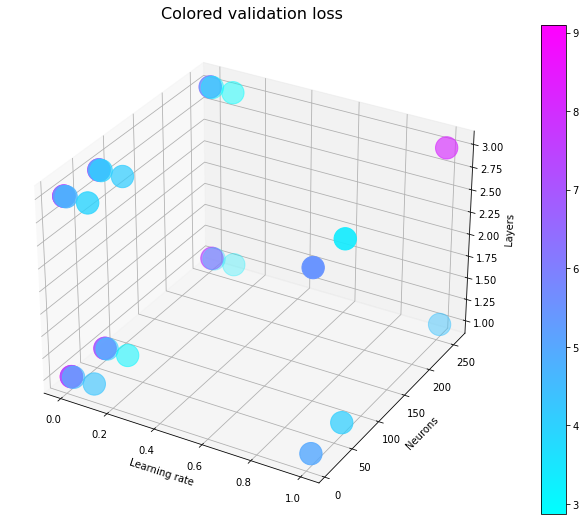

In [39]:
# Define Dataset

x = search_space_result.iloc[:,0].astype(float)
y = search_space_result.iloc[:,1].astype(float)
z = search_space_result.iloc[:,2].astype(float)
col = search_space_result.iloc[:,3].astype(float)
col = np.log(search_space_result.iloc[:,3].astype(float))
 
# Creating figure

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
  
# Creat color map

color_map = plt.get_cmap('cool')
 
# Create scatter plot and colorbar

scatter_plot = ax.scatter3D(x, y, z,
                            c=col,
                            cmap = color_map,s=500)
 
plt.colorbar(scatter_plot)
ax.set_xlabel("Learning rate", rotation=0)
ax.set_ylabel("Neurons", rotation=0)
ax.set_zlabel("Layers", rotation=180)
ax.set_title('Colored validation loss',fontsize=16)

In [23]:
plt.scatter(search_space_result.iloc[:,0],search_space_result.iloc[:,3])
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Validation loss")

Text(0, 0.5, 'Validation loss')

## Model analysis

Now the best and worst models can be compared, to illustrate the imporantance of proper hyperparameter tuning.

In [24]:
best_model_index = np.where(search_space_result.result==np.min(search_space_result.result))[0].item()

worst_model_index =  np.where(search_space_result.result==np.max(search_space_result.result))[0][0]


In [25]:
search_space_result.iloc[best_model_index,:]

learning_rate          0.1
n_neurons              256
n_layers                 3
result           17.699987
Name: 29, dtype: object

In [26]:
best_model = result_list_models[best_model_index]
worst_model = result_list_models[worst_model_index]

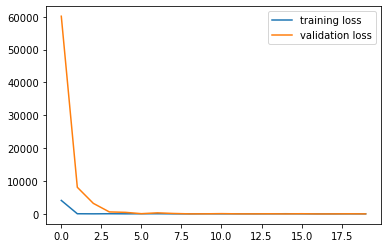

In [27]:
plt.plot(result_list_history[best_model_index].history['loss'],label="training loss")
plt.plot(result_list_history[best_model_index].history['val_loss'],label="validation loss")
plt.legend()


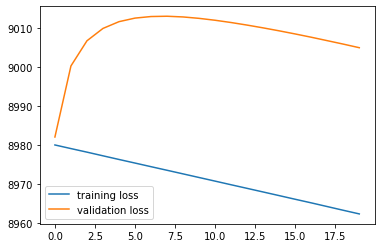

In [28]:
plt.plot(result_list_history[worst_model_index].history['loss'],label="training loss")
plt.plot(result_list_history[worst_model_index].history['val_loss'],label="validation loss")
plt.legend()

Text(0, 0.5, 'Predictions')

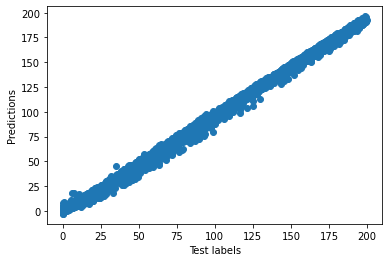

In [29]:
plt.scatter(test_labels,best_model.predict(test_features))
plt.xlabel("Test labels")
plt.ylabel("Predictions")

Text(0, 0.5, 'Predictions')

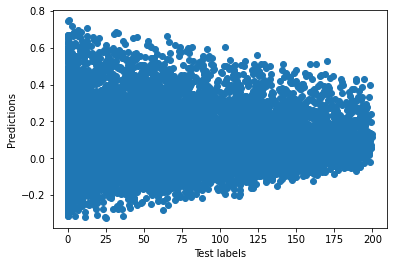

In [30]:
plt.scatter(test_labels,worst_model.predict(test_features))
plt.xlabel("Test labels")
plt.ylabel("Predictions")

The model can be analyzed with respect to its behaviour when pricing different product categories (e.g. ITM vs OTM, high vs low maturities).

In [31]:
deviations = best_model.predict(test_features).reshape(-1,1)-test_labels.reshape(-1,1)
moneyness = test_features[:,0].reshape(-1,1)-test_features[:,1].reshape(-1,1)
maturity = test_features[:,3].reshape(-1,1)

In [32]:
kdeplot_data = pd.DataFrame({"Deviations":deviations.squeeze(),"Maturity": maturity.squeeze(),"ITM":moneyness.squeeze()>0})

<AxesSubplot:xlabel='Maturity', ylabel='Deviations'>

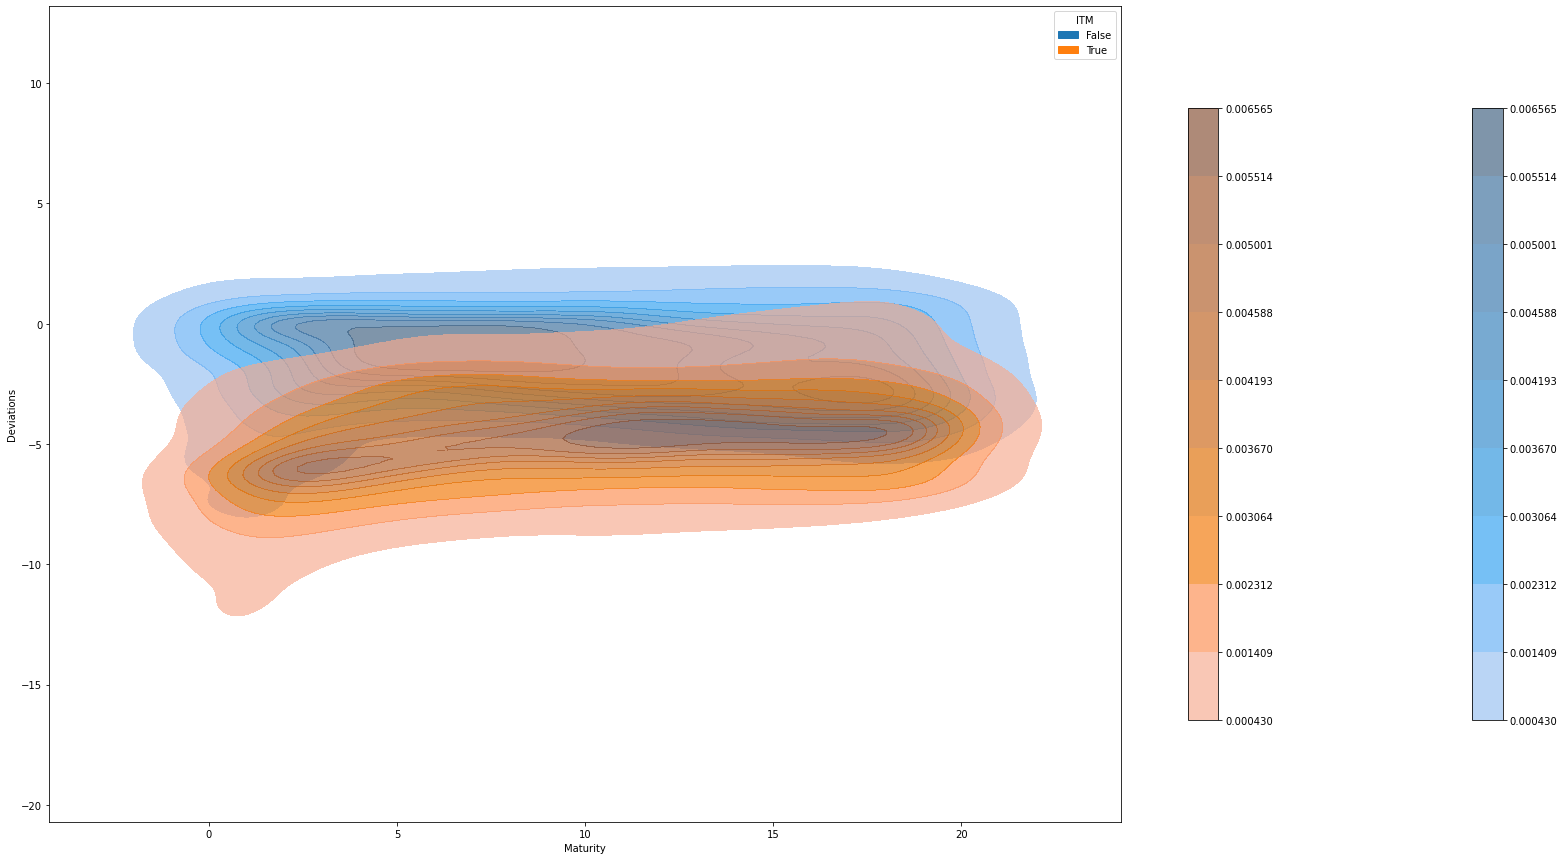

In [33]:
plt.figure(figsize=(30,15))
sns.kdeplot(data=kdeplot_data, x="Maturity", y="Deviations",hue="ITM", fill=True,
            cbar = True, cbar_kws=dict(shrink=0.75), shade=True, alpha = 0.66)